## <center> **Livrable n°1 : Classification binaire** </center>

‎ 

Réalisé par le **groupe n°X** :
- GAURE Warren
- Membre n°2
- Membre n°3
- Membre n°4

‎

---


### **Sommaire**

1. [Mise en contexte](#contexte)
2. [Objectif du livrable](#objectif)
3. [Importation des bibliothèques](#import)
4. [Chargement et préparation des données](#load)
5. [Exploration et visualisation des données](#exploration)
6. [Configuration de l'environnement](#configuration)
7. [Choix de l'architecture](#architecture)
8. [Réalisation du modèle](#modele)
9. [Entraînement et évaluation du modèle](#train)
10. [Amélioration du modèle](#amelioration)
11. [Modèle final](#final)
12. [Conclusion](#conclusion)

‎ 

---

### 1. <a id='contexte'>Mise en contexte</a>

L’entreprise TouNum est spécialisée dans la numérisation de documents, qu’il s’agisse de textes ou d’images. Ses services sont particulièrement sollicités par des entreprises cherchant à transformer leur base documentaire papier en fichiers numériques exploitables. Aujourd’hui, TouNum souhaite aller plus loin en enrichissant son offre avec des outils basés sur le Machine Learning.

En effet, certains clients disposent d’un volume considérable de documents à numériser et expriment un besoin croissant pour des solutions de catégorisation automatique. Une telle innovation leur permettrait d’optimiser le traitement et l’exploitation de leurs données numérisées. Toutefois, TouNum ne dispose pas en interne des compétences nécessaires pour concevoir et mettre en place ces technologies.

C’est dans ce cadre que notre équipe de spécialistes en Data Science du CESI est sollicitée. Notre mission consiste à développer une première solution intégrant du captioning automatique : un système capable d’analyser des photographies et de générer une légende descriptive de manière autonome.

Heureusement, TouNum possède déjà plusieurs milliers d’images annotées, ce qui constituera une ressource précieuse pour entraîner les modèles de Machine Learning à partir d’un apprentissage supervisé.

---

### 2. <a id='objectif'>Objectif du livrable</a>

TouNum souhaite automatiser la sélection des photos destinées à l'annotation. Ce livrable propose une méthode de classification basée sur les réseaux de neurones pour filtrer les images qui ne sont pas des photos. La solution reposera sur l'architecture de réseau retenue en fonction des résultats obtenus.

---

### 3. <a id='import'>Importation des bibliothèques</a>

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from imblearn.over_sampling import SMOTE

---

### 4. <a id='load'>Chargement et préparation des données</a>

Nous allons maintenant charger et préparer les données fournies par TouNum.

Les images doivent être séparées en deux ensembles : l'un pour entraîner le modèle, l'autre pour l'évaluer.

In [79]:
dataset_path = './dataset_livrable_1'
image_h = 180
image_w = 180
batch_s = 32

train_set = keras.utils.image_dataset_from_directory(
    dataset_path,
    label_mode = "int",
    batch_size = batch_s,
    image_size = (image_h, image_w),
    seed = 42,
    validation_split = 0.2,
    subset = "training"
)

test_set = keras.utils.image_dataset_from_directory(
    dataset_path,
    label_mode = "int",
    batch_size = batch_s,
    image_size = (image_h, image_w),
    seed = 42,
    validation_split = 0.2,
    subset = "validation",
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


La sortie indique la présence de **XXXX** fichiers au total, dont **XXXX** appartenant au jeu d'entraînement et **XXXX** au jeu de test.

Une fois les données réparties dans les deux ensembles, nous pouvons afficher le nom des labels.

In [66]:
class_names = train_set.class_names
print(f"Classes détectées : {class_names}")

Classes détectées : ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Notre jeu de données contient 5 catégories, mais nous cherchons simplement à distinguer les photos des autres images. Nous devons donc modifier les labels pour reformuler le problème en classification *binaire*.

In [80]:
photo_index = class_names.index('tulips')

def binary_conversion(image, label):
    return image, tf.cast(tf.equal(label, photo_index), tf.int32)

train_set = train_set.map(binary_conversion)
test_set = test_set.map(binary_conversion)

for image, label in train_set.take(1):
    print(f"Labels après conversion : {label.numpy()}")

Labels après conversion : [0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]


Comme observé dans la sortie, la conversion est réussie et nous avons bien uniquement deux labels, `1` pour les photos et `0` pour les images qui ne sont pas des photos.

Après conversion des labels, nous devons nous assurer de la répartition équitable des données.

In [68]:
def print_label_distribution(dataset):
    nb_photos = sum(1 for _, label in dataset.unbatch() if label.numpy() == 1)
    nb_non_photos = sum(1 for _, label in dataset.unbatch() if label.numpy() == 0)
    total = nb_photos + nb_non_photos

    print(f"Nombre total d'images : {total}")
    print(f"Nombre de photos : {nb_photos} ({nb_photos/total*100:.2f}% du total)")
    print(f"Nombre de 'non-photos' : {nb_non_photos} ({nb_non_photos/total*100:.2f}% du total)")

print_label_distribution(train_set)

Nombre total d'images : 2936
Nombre de photos : 617 (21.01% du total)
Nombre de 'non-photos' : 2319 (78.99% du total)


La répartition des données est déséquilibrée, avec une majorité d'images non-photographiques. Pour corriger cela, nous allons utiliser la [Data Augmentation](https://en.wikipedia.org/wiki/Data_augmentation).

Il s'agit d'une technique permettant de générer artificiellement de nouvelles images en appliquant des transformations aléatoires aux données existantes. Elle permet d'améliorer la généralisation du modèle en le rendant plus robuste aux variations comme l’orientation, la luminosité ou le zoom. Dans ce projet, la Data Augmentation est appliquée uniquement aux images de la classe minoritaire afin de rééquilibrer le dataset. Ainsi, le modèle évite d’apprendre un biais dû à un déséquilibre entre les classes.

In [81]:
#data_augmentation = [
#    layers.RandomFlip(input_shape=(image_h, image_w, 3), mode='horizontal_and_vertical'),
#    layers.RandomRotation(factor=0.1, fill_mode='nearest'),
#    layers.RandomZoom(height_factor=0.1, fill_mode='nearest')
#]

#def augment_photos(image, label):
#    if label == 1:  # Vérification pour éviter les erreurs avec tf.data
#        image = data_augmentation(image)
#    return image, label

#def oversample_photos(dataset, augmentation_factor=2):
#    photos = dataset.filter(lambda image, label: tf.reduce_all(tf.equal(label, 1)))
#    non_photos = dataset.filter(lambda image, label: tf.reduce_all(tf.equal(label, 0)))

#    augmented_photos = photos.map(augment_photos).repeat(augmentation_factor)
    
#    balanced_train_set = non_photos.concatenate(augmented_photos).shuffle(1000).batch(batch_s)

#    return balanced_train_set


#train_set = oversample_photos(train_set)

X_train = np.array([image.numpy() for image, label in train_set.unbatch()])
y_train = np.array([label.numpy() for image, label in train_set.unbatch()])

smote = SMOTE(sampling_strategy=0.45, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

X_resampled = X_resampled.reshape(-1, 180, 180, 3)

train_set = tf.data.Dataset.from_tensor_slices((X_resampled, y_resampled)).shuffle(1000).batch(batch_s)

print_label_distribution(train_set)

Nombre total d'images : 3362
Nombre de photos : 1043 (31.02% du total)
Nombre de 'non-photos' : 2319 (68.98% du total)


Les données sont bien plus équilibrées dès à présent.

<b style="color:yellow;">TODO</b>

- Déplacer le texte sur la Data Augmentation (et le code associé) dans la section 10
- Revoir la section 10 en conséquence des changements
- Écrire un texte décrivant le sur-échantillonnage (oversampling) et SMOTE (avec la librairie imbalanced-learn)
- Continuer les tests en entraînant le modèle
- Continuer à modifier `livrable1.ipynb` par rapport aux observations faites ici

---

### 5. <a id='exploration'>Exploration et visualisation des données</a>

Une fois les données chargées et les labels modifiés, nous pouvons examiner plus en détail les images.

Nous affichons quelques images pour regarder plus en détail ce à quoi nous avons affaire.

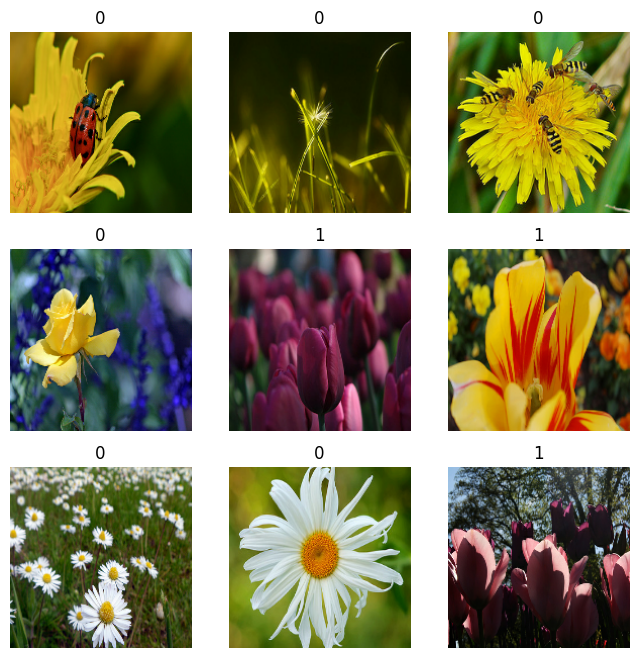

In [48]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy())
        plt.axis("off")

Enfin, nous affichons la taille des données, information pouvant être utile pour gérer les performances de notre modèle.

In [49]:
images, labels = next(iter(train_set.take(1)))
print(f"Tensor des images : {images.shape}")
print(f"Tensor des labels : {labels.shape}")

Tensor des images : (32, 180, 180, 3)
Tensor des labels : (32,)


---

### 6. <a id='configuration'>Configuration de l'environnement</a>

Pour optimiser les performances des calculs, nous allons configurer les données à l’aide de deux fonctions : `Dataset.cache` et `Dataset.prefetch`.  
- [`Dataset.cache`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) stocke les données en mémoire pour éviter les accès répétés au disque.  
- [`Dataset.prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) permet de traiter un élément en arrière-plan pendant l'entraînement ou l'évaluation.  

En combinant ces techniques, nous réduirons significativement le temps de traitement et la charge computationnelle.

In [50]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

---

### 7. <a id='architecture'>Choix de l'architecture</a>

Nous avons choisi une architecture basée sur les **réseaux de neurones convolutifs (CNN)**, particulièrement adaptés à la classification binaire d’images. Contrairement aux réseaux classiques (MLP), qui traitent chaque pixel indépendamment, les CNN exploitent les relations entre pixels pour mieux détecter les motifs et les formes. Grâce à leurs **filtres partagés**, ils réduisent considérablement le nombre de paramètres, rendant l’entraînement plus rapide et limitant le surapprentissage. Ces propriétés en font une solution puissante et efficace pour notre problème.

---

### 8. <a id='modele'>Réalisation du modèle</a>

Maintenant que le choix de l'architecture est fait, nous pouvons commencer à créer le modèle que nous allons utiliser pour classifier les images envoyées par l'entreprise.

Notre modèle sera structuré autour des blocs suivants :  
- Une **couche de rescaling** pour normaliser les valeurs des composantes RGB des pixels dans l'intervalle `[0;1]`.  
- Une **première convolution** avec 16 filtres de taille 3x3 (`Conv2D`), suivie d'un **max pooling** pour réduire la dimension spatiale.  
- Une **seconde convolution** utilisant 32 filtres de taille 3x3.  
- Une **troisième convolution** avec 64 filtres de taille 3x3.  
- Une **transformation en vecteur** via une opération d'aplatissement (`Flatten`).  
- Une **couche dense** de 128 unités pour capturer les caractéristiques extraites.  
- Enfin, une **sortie entièrement connectée** avec 1 unité, correspondant à la classe cible.  

In [51]:
num_classes = 1

model = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

L'optimiseur [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) est choisi pour sa capacité d'adaptation et sa rapidité de convergence, combinant les avantages de [`Momentum`](https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/MomentumOptimizer) et [`RMSprop`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop).

La fonction de perte [`BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) est utilisée car elle est plus efficace en mémoire et bien adaptée à la classification binaire.

Le code suivant va permettre d'avoir un résumé du modèle tel qu'il est à ce stade.

In [52]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

---

### 9. <a id='train'>Entraînement et évaluation du modèle</a>

Avec le modèle créé, nous pouvons désormais procéder à son entraînement et son évaluation avec les ensembles de données à notre disposition.

In [ ]:
epochs = 10
epochs_range = range(epochs)

history = model.fit(
    train_set,
    validation_data = test_set,
    epochs = epochs
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 867ms/step - accuracy: 0.7213 - loss: 2.7473 - val_accuracy: 0.7629 - val_loss: 0.4966
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 78s 846ms/step - accuracy: 0.8059 - loss: 0.4268 - val_accuracy: 0.7888 - val_loss: 0.5131
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 840ms/step - accuracy: 0.8974 - loss: 0.2709 - val_accuracy: 0.7725 - val_loss: 0.6229
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 811ms/step - accuracy: 0.9502 - loss: 0.1456 - val_accuracy: 0.7902 - val_loss: 0.7358
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 70s 766ms/step - accuracy: 0.9854 - loss: 0.0594 - val_accuracy: 0.7520 - val_loss: 0.7550
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 70s 764ms/step - accuracy: 0.9863 - loss: 0.0421 - val_accuracy: 0.7657 - val_loss: 1.1405
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 71s 776ms/step - accuracy: 0.9938 - loss: 0.0248 - val_accuracy: 0.7657 - val_loss: 1.0152
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 73s 794ms/step - accuracy: 0.9903 - loss: 0.0311 - val_accu

KeyboardInterrupt: 

<b style="color:yellow;">TODO</b>

Analyser les résultats et parler du sur-apprentissage ainsi que de la potentielle instabilité.

---

### 10. <a id='amelioration'>Amélioration du modèle</a>

Afin de palier au surapprentissage observé et d’améliorer la généralisation du modèle, plusieurs techniques de régularisation ont été retenues :

- [**Dropout**](#dropout) : Cette méthode consiste à désactiver aléatoirement un certain pourcentage de neurones à chaque itération lors de l'entraînement. Cela empêche le modèle de devenir trop dépendant de certaines connexions et encourage l'apprentissage de représentations plus robustes. Une valeur typique se situe entre 0.2 et 0.5 selon la complexité du réseau.

- [**Early-Stopping**](#early-stopping) : Cette technique permet d'arrêter automatiquement l'entraînement lorsque la performance sur l’ensemble de validation commence à se dégrader. Elle évite d’entraîner le modèle trop longtemps, ce qui pourrait mener à un surajustement aux données d’entraînement. Un paramètre clé est la `patience`, qui définit le nombre d’époques d'attente avant d'interrompre l'entraînement si aucune amélioration n'est observée.

- [**Régularisation L1 (Lasso)**](#l1) : L1 applique une pénalité sur la somme des valeurs absolues des poids du modèle. Cela pousse certains poids à devenir exactement nuls, ce qui permet une sparsité dans les connexions et peut aider à réduire l'impact des variables les moins importantes. Elle est particulièrement utile pour éliminer les caractéristiques inutiles dans des modèles fortement paramétrés.

- [**Régularisation L2 (Ridge)**](#l2) : L2 impose une pénalité sur la somme des carrés des poids, ce qui réduit la magnitude des paramètres sans les annuler complètement. Cela permet de contrôler des valeurs extrêmes qui pourraient rendre le modèle trop sensible aux fluctuations des données d’entraînement. Cette méthode est couramment utilisée dans les réseaux convolutifs, où il est essentiel d'éviter des poids trop dominants.

En testant et, potentiellement, combinant ces différentes approches, nous parviendrons à obtenir un modèle plus stable, robuste, et capable de mieux généraliser sur des données non vues.

#### 10.1. <a id='dropout'>Dropout</a>

Pour cette approche, nous ajoutons un Dropout de 25% après le MaxPooling et un Dropout de 50% après la couche Dense, en se basant sur l’approche de [Keras pour le dataset MNIST](https://github.com/keras-team/keras/blob/keras-2/examples/mnist_cnn.py). Le premier limite la dépendance aux caractéristiques extraites, tandis que le second réduit le surajustement dans la partie dense.

In [ ]:
model_with_dropout = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid')
])

model_with_dropout.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

model_with_dropout.summary()

Nous pouvons procéder à l'entraînement de cette version du modèle.

In [ ]:
epochs = 10
epochs_range = range(epochs)

history = model_with_dropout.fit(
    train_set,
    validation_data = test_set,
    epochs = epochs
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

──────────────────────────────────────────────────

#### 10.2. <a id='early-stopping'>Early Stopping</a>

Pour cette approche, nous ajoutons un Early Stopping basé sur la perte de validation, avec une patience de 5 époques, afin d’interrompre l’entraînement dès que le modèle cesse de s’améliorer et de conserver les meilleurs poids.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_with_early_stopping = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

model_with_early_stopping.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

model_with_early_stopping.summary()

Nous pouvons procéder à l'entraînement de cette version du modèle.

In [ ]:
epochs = 20
epochs_range = range(epochs)

history = model_with_early_stopping.fit(
    train_set,
    validation_data = test_set,
    epochs = epochs,
    callbacks = [early_stopping]
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

──────────────────────────────────────────────────

#### 10.3. <a id='l1'>Régularisation L1 (Lasso)</a>

Nous allons appliquer une régularisation L1 pour limiter la complexité du modèle en forçant certains poids à devenir exactement nuls.

In [ ]:
model_with_l1 = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l1(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l1(0.01)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l1(0.01)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1(0.01)),
    layers.Dense(num_classes, activation='sigmoid')
])

model_with_l1.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

model_with_l1.summary()

Nous pouvons procéder à l'entraînement de cette version du modèle.

In [ ]:
epochs = 10
epochs_range = range(epochs)

history = model_with_l1.fit(
    train_set,
    validation_data = test_set,
    epochs = epochs
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

──────────────────────────────────────────────────

#### 10.4. <a id='l2'>Régularisation L2 (Ridge)</a>

Nous allons maintenant appliquer une régularisation L2 (Ridge) afin de réduire la magnitude des poids sans les annuler complètement.

In [ ]:
model_with_l2 = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dense(num_classes, activation='sigmoid')
])

model_with_l2.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

model_with_l2.summary()

Nous pouvons procéder à l'entraînement de cette version du modèle.

In [ ]:
epochs = 10
epochs_range = range(epochs)

history = model_with_l2.fit(
    train_set,
    validation_data = test_set,
    epochs = epochs
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

──────────────────────────────────────────────────

#### 10.5. Dropout & Early Stopping

Nous combinons ici Dropout et Early Stopping afin de tester leur impact conjoint sur la régularisation du modèle. L'objectif est de réduire l'overfitting tout en optimisant la durée d'entraînement.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_with_dropout_early_stopping = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid')
])

model_with_dropout_early_stopping.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

model_with_dropout_early_stopping.summary()

Nous pouvons procéder à l'entraînement de cette version du modèle.

In [ ]:
epochs = 20
epochs_range = range(epochs)

history = model_with_dropout_early_stopping.fit(
    train_set,
    validation_data = test_set,
    epochs = epochs,
    callbacks = [early_stopping]
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

──────────────────────────────────────────────────

#### 10.6. Elastic Net (L1 + L2)

Nous allons maintenant tester [Elastic Net](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L1L2), qui combine les avantages de L1 (Lasso) et L2 (Ridge). Cette régularisation permet à la fois de forcer certains poids à zéro (effet L1) et de réduire la magnitude des autres (effet L2), ce qui équilibre la simplification du modèle et sa stabilité.

In [ ]:
model_with_elasticnet = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.005, 0.005)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.005, 0.005)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.005, 0.005)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dense(num_classes, activation='sigmoid')
])

model_with_elasticnet.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

model_with_elasticnet.summary()

Nous pouvons procéder à l'entraînement de cette version du modèle.

In [ ]:
epochs = 10
epochs_range = range(epochs)

history = model_with_elasticnet.fit(
    train_set,
    validation_data = test_set,
    epochs = epochs
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

---

### 11. <a id='final'>Modèle final</a>

<b style="color:yellow;">TODO</b>

Indiquer et justifier le choix du modèle final à l'aide des résultats observés. Faire la passe sur ses caractéristiques, à savoir :
- Paramètres
- Fonction de perte
- Algorithme d'optimisation utilisé pour l'entraînement

Inclure un schéma du modèle réalisé grâce à cet [outil](https://alexlenail.me/NN-SVG/LeNet.html).

---

### 12. <a id='conclusion'>Conclusion</a>

<b style="color:yellow;">TODO</b>

Écrire la conclusion.

---